<h1>MORTGAGE FORECLOSURE PREDICTION</h1>

In [1]:
# import pertinent modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_profiling as pp
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import NearMiss
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report
import os
from sklearn.tree import export_graphviz
import six
import pydot
from sklearn import tree

<h3>Load Fannie Mae Acquisition & Performance Text Files Into DataFrame</h3>

In [2]:
# load Fannie Mae loan Acquisition Data into DataFrame
df_acquisition = pd.DataFrame()
df_acquisition = pd.read_csv(r'Temp\Acquisition_2008Q4.txt', sep = "|", header=None
                          , names=['Loan_ID', 'Orig_Channel', 'Seller_Name', 'Orig_Int_Rate', 'Orig_UPB'
                          , 'Orig_Loan_Term','Origination_Date', 'First_Pmt_Date', 'Orig_LTV', 'Orig_CLTV'
                          ,'Num_Borrowers', 'Orig_Debt_Inc_Ratio', 'Borrower_Credit_Score'
                          , 'First_Time_Home_Buyer_Ind','Loan_Purpose', 'Property_Type', 'Number_Units'
                          , 'Occupancy_Type', 'Property_State', 'Zip_Code', 'Primary_Mortg_Insur_Percent'
                          ,'Product_Type', 'Coborrower_Credit_Score', 'Mortg_Insur_Type'
                          ,'Relocation_Mortg_Ind']) 
#Copy of Acquisition_2008Q4.zip can be found at the link below
#https://drive.google.com/file/d/1dhv1sKy5TP5hpLKmligEO5tLIyjk79LP/view?usp=sharing

In [3]:
# Load Fannie Mae Loan Performance Data to DataFrame
df_performance = pd.DataFrame()
df_performance = pd.read_csv(r'Temp\Performance_2008Q4.txt', sep = "|", header=None
                            , names=['Loan_ID', 'Reporting_Period', 'Servicer_Name', 'Current_Int_Rate'
                            , 'Current_Act_UPB', 'Loan_Age','Remain_Months_Legal_Maturity'
                            , 'Adj_Months_Maturity', 'Maturity_Date', 'Metro_Stat_Area'
                            ,'Current_Loan_Delinq_Status', 'Modification_Flag', 'Zero_Balance_Code'
                            , 'Zero_Balance_Effective_Date','Last_Paid_Install_Date', 'Foreclosure_Date'
                            , 'Disposition_Date', 'Foreclosure_Costs','Property_Preserv_Repair_Costs'
                            , 'Asset_Recovery_Costs', 'Misc_Holding_Expenses_Credits'
                            ,'Associated_Taxes_Holding_Property', 'Net_Sale_Proceeds'
                            , 'Credit_Enhancement_Proceeds','Repurchase_Make_Whole_Proceeds'
                            , 'Other_Foreclosure_Proceeds', 'Non_Interest_Bearing_UPB','Principal_Forgiveness_Amt'
                            , 'Repurchase_Make_Whole_Proceeds_Flag', 'Foreclosure_Principal_Writeoff_Amt'
                            ,'Servicing_Activity_Indicator'])
#Copy of Performance_2008Q4.zip can be found at the link below
#https://drive.google.com/file/d/1DlzF6TG17Vl-LC1yOsCPgXedjjjIxdsT/view?usp=sharing

<h3>Clean Data and Merge DataFrames</h3>

In [4]:
# Remove all but rows with Zero_Balance_Codes that indicate account has been closed
df_performance = df_performance[df_performance['Zero_Balance_Code'].notna()]

# Keep only performance data representing foreclosures information (Foreclosure_Date & Zero_Balance_Code)
df_performance = df_performance[['Loan_ID', 'Zero_Balance_Code', 'Foreclosure_Date']]

In [5]:
# Join data from the acquisition and performance DataFrames
df = df_acquisition.merge(df_performance, on="Loan_ID", how="inner")

In [6]:
# Add classification column, 1=defaulted, 0=not defaulted
df['Classification'] = [1 if pd.notnull(x) else 0 for x in df['Foreclosure_Date']]

In [7]:
# Fill in and clean up data

# Add in Num_Borrowers value for those that are NaN
df['Num_Borrowers'] = np.where(df['Num_Borrowers'].notnull(), df['Num_Borrowers']                                        
                                           ,np.where(np.logical_and(df['Num_Borrowers'].isnull()
                                           ,df['Coborrower_Credit_Score'].isnull()), 1, 2))

# Drop rows with conflicting number of borrowers and co-borrower credit score data
df = df[((df['Num_Borrowers'] > 1) & (df['Coborrower_Credit_Score'].notnull()) | (df['Num_Borrowers']==1) 
         & df['Coborrower_Credit_Score'].isnull())]

# Drop rows without borrower credit score
df = df.dropna(subset=['Borrower_Credit_Score'], how='all')

# Orig_CLTV make NaN values equal to Orig_LTV
df['Orig_CLTV'].fillna(df['Orig_LTV'], inplace=True)

# Orig_Debt_Inc_Ratio make NaN values equal to median value of column
debt_ratio = np.nanmedian(df['Orig_Debt_Inc_Ratio'])
df['Orig_Debt_Inc_Ratio'].fillna(debt_ratio, inplace=True)

# Coborrower_Credit_Score make NaN values equal to Borrower_Credit_Score
df['Coborrower_Credit_Score'].fillna(df['Borrower_Credit_Score'], inplace=True)

# First_Time_Home_Buyer_Ind make Y = 1 else 0
df['First_Time_Home_Buyer_Ind'] = [1 if x == 'Y' else 0 if x in ['N','U'] else 
                                   df['First_Time_Home_Buyer_Ind']
                                   for x in df['First_Time_Home_Buyer_Ind']]

# Property_Type make SF (Single Family) = 1, PU (Planned Unit Development) = 2, CO (Condo) = 3, CP (Co-Op) = 4,
# MH (Multi House) = 5
df['Property_Type'] = [1 if x == 'SF' else 2 if x == 'PU' else 3 if x == 'CO' else 4 if x == 'CP' 
                       else 5 if x == 'MH' else df['Property_Type'] for x in df['Property_Type']]

# Loan_Purpose make P (Purchase) = 1, C (Cash-Out Refinance) = 2, R (Cash-Out No Refinance) = 3
df['Loan_Purpose'] = [1 if x == 'P' else 2 if x == 'C' else 3 if x == 'R' else df['Loan_Purpose'] 
                      for x in df['Loan_Purpose']]

# Occupancy_Type make P (Principal) = 1, I (Investment) = 2, S (Second) = 3
df['Occupancy_Type'] = [1 if x == 'P' else 2 if x == 'I' else 3 if x == 'S' else df['Occupancy_Type'] 
                        for x in df['Occupancy_Type']]

<h3>Summarize Features Using Pandas ProfileReport</h3>

In [8]:
pp.ProfileReport(df)

Number of variables,29
Number of observations,292705
Total Missing (%),8.9%
Total size in memory,64.8 MiB
Average record size in memory,232.0 B
Numeric,17
Categorical,7
Boolean,2
Date,0
Text (Unique),0
Rejected,3


<h3>Identify Features to Be Used in Model</h3>

In [9]:
# Identify features and target to be included in classification model
features = ['Borrower_Credit_Score', 'Coborrower_Credit_Score','Orig_Debt_Inc_Ratio','Orig_LTV','Orig_UPB', 
            'First_Time_Home_Buyer_Ind', 'Loan_Purpose', 'Property_Type','Num_Borrowers','Occupancy_Type', 'Zip_Code']
X = df[features]
y = df['Classification']

<h3>Test Three Classifiers (Random Forest, KNN, and Logistic Regression) And Measure F1 Score</h3>

In [10]:
# Random forest classifier
def random_forest(n_estimator, max_feature, min_samples_split):
    global y_test, y_predict, model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=0)
    model = RandomForestClassifier(n_estimators=n_estimator, random_state=0, max_features=max_feature, 
                                   min_samples_split=min_samples_split)
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    return y_test, y_predict, model

In [11]:
# Initial random forest run of model using default hyperparameters
random_forest(100, int(np.sqrt(len(features))), 2)
print(classification_report(y_test, y_predict))    

             precision    recall  f1-score   support

          0       0.97      1.00      0.98     70885
          1       0.68      0.02      0.04      2292

avg / total       0.96      0.97      0.95     73177



In [12]:
# Resample data for undersampling
nr = NearMiss()
X, y = nr.fit_sample(X, y)

In [13]:
# Random Forest run after resampling of model using default hyperparameters
random_forest(100, int(np.sqrt(len(features))), 2)
print(classification_report(y_test, y_predict))    

             precision    recall  f1-score   support

          0       0.79      0.77      0.78      2402
          1       0.78      0.79      0.79      2430

avg / total       0.78      0.78      0.78      4832



In [14]:
# k nearest neighbors
X_train, X_test, y_train, y_test = train_test_split( 
             X, y, test_size = 0.25, random_state=0) 
  
knn = KNeighborsClassifier(n_neighbors=5) 
  
knn.fit(X_train, y_train) 

y_predict = knn.predict(X_test)
print(classification_report(y_test, y_predict)) 

             precision    recall  f1-score   support

          0       0.72      0.89      0.80      2402
          1       0.86      0.66      0.75      2430

avg / total       0.79      0.78      0.77      4832



In [15]:
# Logistic regression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, 
                                                    random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_predict = logreg.predict(X_test)
print(classification_report(y_test, y_predict)) 

             precision    recall  f1-score   support

          0       0.65      0.59      0.62      2402
          1       0.63      0.69      0.66      2430

avg / total       0.64      0.64      0.64      4832



<h3>Random Forest has the Highest F1 Score and Selected</h3>

In [16]:
# Tune n_estimators values to determine highest f1 score
n_estimators = [10, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
score = 0
n = 0
for n_estimator in n_estimators:
    random_forest(n_estimator, int(np.sqrt(len(features))), 2)
    f1 = f1_score(y_test, y_predict)
    if f1 > score:
        score = f1
        n = n_estimator
print(n, ': Number of trees to use for model')
print(score, ': f1_score')

400 : Number of trees to use for model
0.79026369168357 : f1_score


In [17]:
# Tune max_features and min_sample_splits to determine highest f1 score
max_features = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
min_samples_splits = [2, 4, 8, 16, 32, 64, 128, 256]
score = 0
max_feat = 0
min_ss = 0

for max_feature in max_features:
    for min_samples_split in min_samples_splits:
        random_forest(n, max_feature, min_samples_split)
        f1 = f1_score(y_test, y_predict)
        if f1 > score:
            score = f1
            max_feat = max_feature
            min_ss = min_samples_split
print(score, ': f1_score')
print(max_feat, ': max_feature')
print(min_ss, ': min_sample_split')

0.7966540529774947 : f1_score
2 : max_feature
64 : min_sample_split


In [18]:
# Final prediction using tuned hyperparameters
random_forest(n, max_feat, min_ss)
print(classification_report(y_test, y_predict)) 

             precision    recall  f1-score   support

          0       0.81      0.75      0.78      2402
          1       0.77      0.82      0.80      2430

avg / total       0.79      0.79      0.79      4832



In [19]:
# Feature importance summary
for i in range(len(features)):
    print(round(model.feature_importances_[i],4), features[i]) 

0.1412 Borrower_Credit_Score
0.1347 Coborrower_Credit_Score
0.0423 Orig_Debt_Inc_Ratio
0.1254 Orig_LTV
0.3142 Orig_UPB
0.0082 First_Time_Home_Buyer_Ind
0.049 Loan_Purpose
0.0183 Property_Type
0.009 Num_Borrowers
0.0322 Occupancy_Type
0.1256 Zip_Code


<h3>Summary of Feature Importances</h3>

In [20]:
# Combine features and feature importances
zipped = zip(features, model.feature_importances_)
importances, features = zip(*sorted(zip(list(model.feature_importances_), features)))

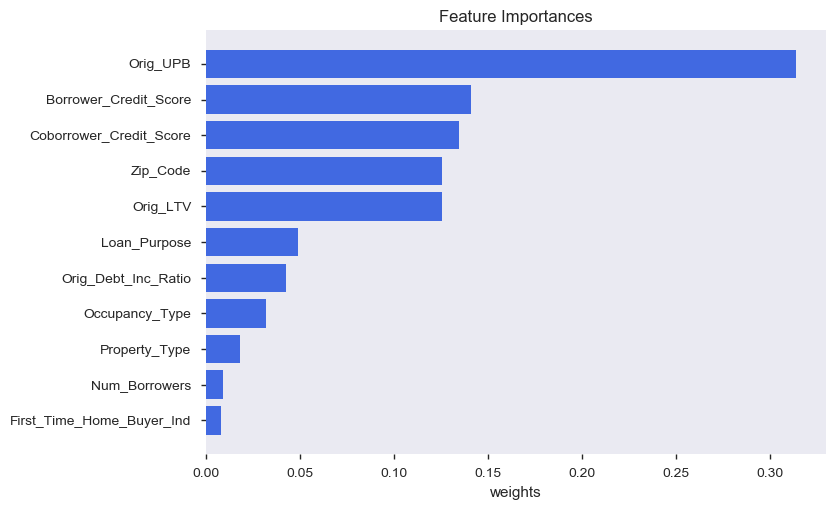

In [21]:
# Graph feature importances in descending order
_ = plt.barh(list(range(0,11)), importances, color='royalblue')
_ = plt.yticks(np.arange(11), list(features))
_ = plt.grid(False)
_ = plt.xlabel('weights')
_ = plt.title('Feature Importances')

<h3>Save First 10 Decision Trees to File</h3>

In [22]:
dotfile = six.StringIO()
i_tree = 0
for tree_in_forest in model.estimators_[0:10]:
    export_graphviz(tree_in_forest,out_file='tree.dot',
    feature_names=features,
    filled=True,
    rounded=True)
    (graph,) = pydot.graph_from_dot_file('tree.dot')
    name = 'tree' + str(i_tree)
    graph.write_png(name+  '.png')
    os.system('dot -Tpng tree.dot -o tree.png')
    i_tree +=1